In [ ]:
import torch as t
import torch.nn as nn
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
def get_data(batch_size):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root="./_data", train=True, download=True,
        transform=transforms
    )
    train_loader = t.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=1
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root="./_data", train=False, download=True,
        transform=transforms
    )
    test_loader = t.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
    )
    
    return train_loader, test_loader

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # shape: (64, 16, 16)
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # shape: (128, 8, 8)
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # shape: (256, 4, 4)
            nn.BatchNorm2d(256),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        conv = self.conv_layers(x).flatten(-3)
        return self.linear_layers(conv)
    
def loader_gen(loader):
    for x in loader: yield x

if t.cuda.device_count(): device = 'cuda:0'
else: device = 'cpu'

model = ConvNet()
print('num model params:', sum([p.numel() for p in model.parameters()]))

n_epochs, batch_size = 3, 100
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())
train_loader, test_loader = get_data(batch_size)
val_freq = int(len(train_loader) / len(test_loader))
losses, val_losses = [], []

model.train()
with tqdm(total = n_epochs * len(train_loader)) as pbar:
    for epoch in range(n_epochs):
        val_iter = loader_gen(test_loader)
        val_loss = float('inf')
        
        for i, (X, y) in enumerate(train_loader):
            X.to(device), y.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.detach())
            pbar.update()
            
            if i % val_freq == 0:
                val_X, val_y = next(val_iter)
                val_X.to(device), val_y.to(device)
                with t.no_grad():
                    val_y_pred = model(val_X)
                    val_loss = loss_fn(val_y_pred, val_y)
                val_losses.append((epoch * len(train_loader) + i, val_loss.detach()))
                
            pbar.set_postfix({'train loss': '%.4f' % float(loss.detach()), 'val loss': '%.4f' % float(val_loss.detach())})
                
                
                
            

num model params: 5852234
Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████| 1500/1500 [11:07<00:00,  2.25it/s, train loss=0.4285, val loss=0.4443]


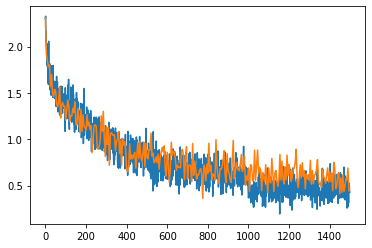

In [ ]:
plt.plot(losses)
plt.plot(*zip(*val_losses));

In [ ]:
# Simple accuracy score 

model.eval()

correct, total = 0, 0
for X, y in tqdm(test_loader):
    y_pred = model(X)
    correct += sum(y_pred.argmax(1) == y)
    total += y.shape[0]
    
print(correct / total)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.99it/s]

tensor(0.8005)


In [ ]:
# Are classes balanced?
from collections import Counter

c = Counter()
[c.update(y.tolist()) for X, y in train_loader]
[c.update(y.tolist()) for X, y in test_loader]
plt.bar(*zip(*sorted(c.items(), key=lambda kv: kv[0])));

c

**Basin dimensionality code**

In [ ]:
import functools, operator

# Unfinished, based on https://discuss.pytorch.org/t/computing-hessian-for-loss-function/67216
# This is for the slow way of computing dimensionality, just to cross-check on mnist
def hessian(model):
  loss = torch.nn.CrossEntropyLoss         
  loss.backward(retain_graph=True)
  grad_params = torch.autograd.grad(loss, p, create_graph=True)  # p is the weight matrix for a particular layer 
  hess_params = torch.zeros_like(grad_params[0])

  for i in range(grad_params[0].size(0)):
      for j in range(grad_params[0].size(1)):
          hess_params[i, j] = torch.autograd.grad(grad_params[0][i][j], p, retain_graph=True)[0][i, j]

# Number of parameters
def nParams(model):
  sum = 0
  for params in model.parameters():
    sum += functools.reduce(operator.mul, params.size())
  return sum

#print(nParams(model))

# Binary seach to find basin dimensionality
def basinDimensionality(model):
  N = nParams(model)
  min = 0
  max = N
  while min != max:
    k = min + (max-min)//2
    result = testDim(model, k, N)
    if result == "no solution":
      max = k-1
    elif result == "solution":
      min = k
    else:
      print("grey area -- parallel at " + k)
      return k
  return k


# Converts a model to a flattened parameter vector
def modelToVec(model):
  return torch.tensor(model.parameters()).flatten().detach()

# Loads a parameter vector into a model
def vecToModel(vec, blank):
  with torch.no_grad():
    index = 0
    for paramset in blank.parameters():
      end = index + functools.reduce(operator.mul, paramset.size())
      paramset.copy_(vec[index : end])
      index = end
    return blank

# Test whether the dimension we guessed is too high or too low. Called from the binary search.
def testDim(model, k, N):
  #Centered
  

  #Uncentered

  pass